In [1]:
!pip install plotly
!pip install cufflinks

In [2]:
import re
import traceback
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
 
import seaborn as sns
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=False)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=False)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline(connected=True)
 
import warnings
warnings.filterwarnings("ignore")
from multiprocessing import cpu_count
%matplotlib inline

Output hidden; open in https://colab.research.google.com to view.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/My Drive/kalapa/dataset/train.csv')
train = train.drop(1311)
test = pd.read_csv('/content/drive/My Drive/kalapa/dataset/test.csv')
test_id = test['id']
df = pd.concat([train, test])
print('Data shape: ', df.shape)

Data shape:  (73410, 195)


In [5]:
def get_len(x):
    if x is np.nan:
        return 0
    else:
        return len(x)

In [6]:
time_field = [
    'Field_1', 'Field_2', 'Field_3', 'Field_5', 'Field_6', 'Field_7','Field_8',
    'Field_9', 'Field_11', 'Field_15', 'Field_25', 'Field_32', 'Field_33',
    'Field_35', 'Field_40', 'Field_43', 'Field_44', 'ngaySinh',
    'F_startDate', 'F_endDate', 'E_startDate', 'E_endDate', 'C_startDate',
    'C_endDate', 'G_startDate', 'G_endDate', 'A_startDate', 'A_endDate'
    ]

cat_field = [
    'Field_4',
    'Field_18', 'Field_12', 'Field_34', 'Field_36', 'Field_38', 'Field_45', 'Field_46',
    'Field_47', 'Field_48', 'Field_49', 'Field_54', 'Field_55', 'Field_56', 'Field_61', 'Field_62',
    'Field_65', 'Field_66', 'Field_68', 'gioiTinh', 'diaChi', 'maCv', 
    'info_social_sex', 'data.basic_info.locale', 'currentLocationCity',
    'currentLocationCountry', 'currentLocationName', 'currentLocationState',
    'homeTownCity', 'homeTownCountry', 'homeTownName', 'homeTownState', 'brief'
    ]

num_field = [col for col in df.columns if col not in time_field+cat_field]
print(num_field)

['id', 'label', 'Field_10', 'Field_13', 'Field_14', 'Field_16', 'Field_17', 'Field_19', 'Field_20', 'Field_21', 'Field_22', 'Field_23', 'Field_24', 'Field_26', 'Field_27', 'Field_28', 'Field_29', 'Field_30', 'Field_31', 'namSinh', 'Field_37', 'Field_39', 'Field_41', 'Field_42', 'Field_50', 'Field_51', 'Field_52', 'Field_53', 'Field_57', 'Field_58', 'Field_59', 'Field_60', 'Field_63', 'Field_64', 'Field_67', 'Field_69', 'Field_70', 'Field_71', 'Field_72', 'Field_73', 'Field_74', 'Field_75', 'Field_76', 'Field_77', 'friendCount', 'subscriberCount', 'currentLocationLocationId', 'currentLocationLatitude', 'currentLocationLongitude', 'homeTownLocationId', 'homeTownLatitude', 'homeTownLongitude', 'topFriends', 'numOrg', 'F_numOrg', 'F_numQuery', 'E_numOrg', 'E_numQuery', 'C_numOrg', 'C_numQuery', 'G_numOrg', 'G_numQuery', 'A_numOrg', 'A_numQuery', 'summary_6m', 'summary_3m', 'summary_1m', 'summary_1w', 'partner0_A', 'partner0_B', 'partner0_C', 'partner0_D', 'partner0_E', 'partner0_F', 'partn

In [7]:
def get_unknown_category(train, test, cat=cat_field):
    result = pd.DataFrame(columns = ['Feature name', 'Train unique', 'Test unique', 'Unknown value'])
    train_unique = train[cat].stack().reset_index(level=0, drop=True)
    train_unique = train_unique.groupby(level=0).unique().reindex(index=train[cat].columns)
    test_unique = test[cat].stack().reset_index(level=0, drop=True)
    test_unique = test_unique.groupby(level=0).unique().reindex(index=test[cat].columns)
    for index, feat in enumerate(cat):
        a = test_unique.loc[feat]
        u1 = train_unique.loc[feat]
        u2 = test_unique.loc[feat]
        unknown = np.where(~np.in1d(u2, u1))[0]
        result.loc[index] = [feat, get_len(u1), get_len(u2), get_len(unknown)]
    return result

In [ ]:
result = get_unknown_category(train.astype(str), test.astype(str))

In [ ]:
for field in time_field:
    df[field] = pd.to_datetime(df[field])

In [ ]:
df.describe(include='all')

,id,label,Field_1,Field_2,Field_3,Field_4,Field_5,Field_6,Field_7,Field_8,Field_9,Field_10,Field_11,Field_12,Field_13,Field_14,Field_15,Field_16,Field_17,Field_18,Field_19,Field_20,Field_21,Field_22,Field_23,Field_24,Field_25,Field_26,Field_27,Field_28,Field_29,Field_30,Field_31,Field_32,Field_33,Field_34,Field_35,ngaySinh,namSinh,gioiTinh,...,partner2_H,partner2_K,partner2_L,partner3_A,partner3_B,partner3_C,partner3_D,partner3_E,partner3_F,partner3_G,partner3_H,partner3_K,partner3_L,partner4_A,partner4_B,partner4_C,partner4_D,partner4_E,partner4_F,partner4_G,partner4_H,partner4_K,partner4_L,partner5_A,partner5_B,partner5_C,partner5_D,partner5_E,partner5_F,partner5_G,partner5_H,partner5_K,partner5_L,brief,num_of_phone,Field_78,Field_79,Field_80,Field_81,Field_82
count,73410.000000,53029.000000,34623,34623,34623,34623,34600,34600,34623,34623,34623,34623.00000,9972,9921,34623.0,34623.0,21132,34623.0,34623.0,11406,34623.000000,3.462300e+04,34623.000000,34623.000000,34623.000000,34623.0,34540,34623.0,3.462300e+04,34623.000000,34623.000000,34623.0,34623.0,33828,31572,34539,9208,34623,34623.000000,34623,...,66015.000000,66015.0,66015.0,66015.000000,66015.0,66015.0,66015.000000,66015.000000,66015.0,66015.0,66015.0,66015.0,66015.0,66015.0,66015.0,66015.0,66015.0,66015.0,66015.0,66015.0,66015.0,66015.0,66015.000000,66015.000000,66015.0,66015.0,66015.000000,66015.000000,66015.000000,66015.000000,66015.0,66015.0,66015.0,70334,70210.00000,49986.000000,38533.000000,49880.000000,49450.000000,73410.000000
unique,NaN,NaN,28805,24268,2,2,2019,1995,1300,1522,2059,NaN,942,7,NaN,NaN,1608,NaN,NaN,8690,NaN,NaN,NaN,NaN,NaN,NaN,1693,NaN,NaN,NaN,NaN,NaN,NaN,1604,1952,3100,705,8793,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2017-03-24 20:10:37.620000+00:00,2017-03-24 20:10:37.620000+00:00,1970-01-01 00:00:00.000000002,T1,2018-12-27 00:00:00,2018-12-27 00:00:00,2019-01-01 00:00:00,2019-12-31 00:00:00,2018-12-27 00:00:00,NaN,2019-10-31 00:00:00,G8,NaN,NaN,2013-08-31 00:00:00,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-28 00:00:00,2015-01-01 00:00:00,20180102,2019-10-31 00:00:00,1970-01-01 00:00:00.019900101,NaN,MALE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,343,338,18556,18707,1502,1628,12314,14745,1454,NaN,692,9535,NaN,NaN,737,NaN,NaN,419,NaN,NaN,NaN,NaN,NaN,NaN,1508,NaN,NaN,NaN,NaN,NaN,NaN,1513,2387,434,689,177,NaN,19537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17764,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2016-11-19 10:54:17.297000+00:00,2016-11-19 10:54:17.297000+00:00,1970-01-01 00:00:00.000000001,NaN,2009-04-24 00:00:00,2009-04-24 00:00:00,2009-04-01 00:00:00,2009-06-30 00:00:00,2009-04-24 00:00:00,NaN,2010-05-31 00:00:00,NaN,NaN,NaN,2009-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-06-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-01 00:00:00,2012-10-28 00:00:00,NaN,2014-12-31 00:00:00,1970-01-01 00:00:00.019050616,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2019-12-31 20:06:50.512000+00:00,2019-12-31 20:48:13+00:00,1970-01-01 00:00:00.000000002,NaN,2020-01-01 00:00:00,2020-01-01 00:00:00,2021-01-01 00:00:00,2025-10-31 00:00:00,2020-01-01 00:00:00,NaN,2020-06-26 00:00:00,NaN,NaN,NaN,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-01 00:00:00,2025-12-01 00:00:00,NaN,2020-06-26 00:00:00,1970-01-01 00:00:00.020191024,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
df.head()

,id,label,Field_1,Field_2,Field_3,Field_4,Field_5,Field_6,Field_7,Field_8,Field_9,Field_10,Field_11,Field_12,Field_13,Field_14,Field_15,Field_16,Field_17,Field_18,Field_19,Field_20,Field_21,Field_22,Field_23,Field_24,Field_25,Field_26,Field_27,Field_28,Field_29,Field_30,Field_31,Field_32,Field_33,Field_34,Field_35,ngaySinh,namSinh,gioiTinh,...,partner2_H,partner2_K,partner2_L,partner3_A,partner3_B,partner3_C,partner3_D,partner3_E,partner3_F,partner3_G,partner3_H,partner3_K,partner3_L,partner4_A,partner4_B,partner4_C,partner4_D,partner4_E,partner4_F,partner4_G,partner4_H,partner4_K,partner4_L,partner5_A,partner5_B,partner5_C,partner5_D,partner5_E,partner5_F,partner5_G,partner5_H,partner5_K,partner5_L,brief,num_of_phone,Field_78,Field_79,Field_80,Field_81,Field_82
0,0,1.0,2019-07-24 03:39:02.854000+00:00,2019-07-31 20:10:02+00:00,1970-01-01 00:00:00.000000001,GH,2018-12-27,2018-12-27,2019-01-01,2019-07-31,2018-12-27,1.0,2019-07-31,G8,1.0,1.0,NaT,1.0,1.0,Trung tâm Kinh doanh tiền mặt,0.0,4258600.0,4.5,1.0,16.0,1.0,2018-12-27,1.0,0.0,0.0,0.0,1.0,1.0,2018-12-28,2022-09-01,20180107,2019-07-31,1970-01-01 00:00:00.019910615,0.0,MALE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cb1,1.0,NaN,NaN,NaN,NaN,1
1,1,0.0,NaT,NaT,NaT,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaT,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1.0,NaN,NaN,NaN,NaN,1
2,2,0.0,2019-01-17 07:15:26.367000+00:00,2019-01-17 07:17:45+00:00,1970-01-01 00:00:00.000000002,T1,2019-01-17,2019-01-17,2019-01-01,2019-12-31,2019-01-17,1.0,NaT,NaN,1.0,1.0,2019-01-17,1.0,1.0,NaN,0.0,5000000.0,4.5,1.0,10.0,1.0,2019-01-17,1.0,0.0,0.0,0.0,1.0,1.0,2019-01-17,2023-03-01,20190102,NaT,1970-01-01 00:00:00.019980601,0.0,FEMALE,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,33.0,10.769445,6.466667,0.0,2
3,3,0.0,NaT,NaT,NaT,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,33.0,10.769445,6.466667,0.0,3
4,4,1.0,NaT,NaT,NaT,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,33.0,10.769445,6.466667,0.0,3


# <a id='miss'> Missing data</a>

In [ ]:
# checking missing data
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.to_csv('Missing_data.csv', index = True)
missing_data

,Total,Percent
Field_35,64202,87.456750
Field_12,63489,86.485492
Field_11,63438,86.416020
Field_18,62004,84.462607
maCv,61036,83.143986
...,...,...
partner5_G,7395,10.073559
num_of_phone,3200,4.359079
brief,3076,4.190165
Field_82,0,0.000000


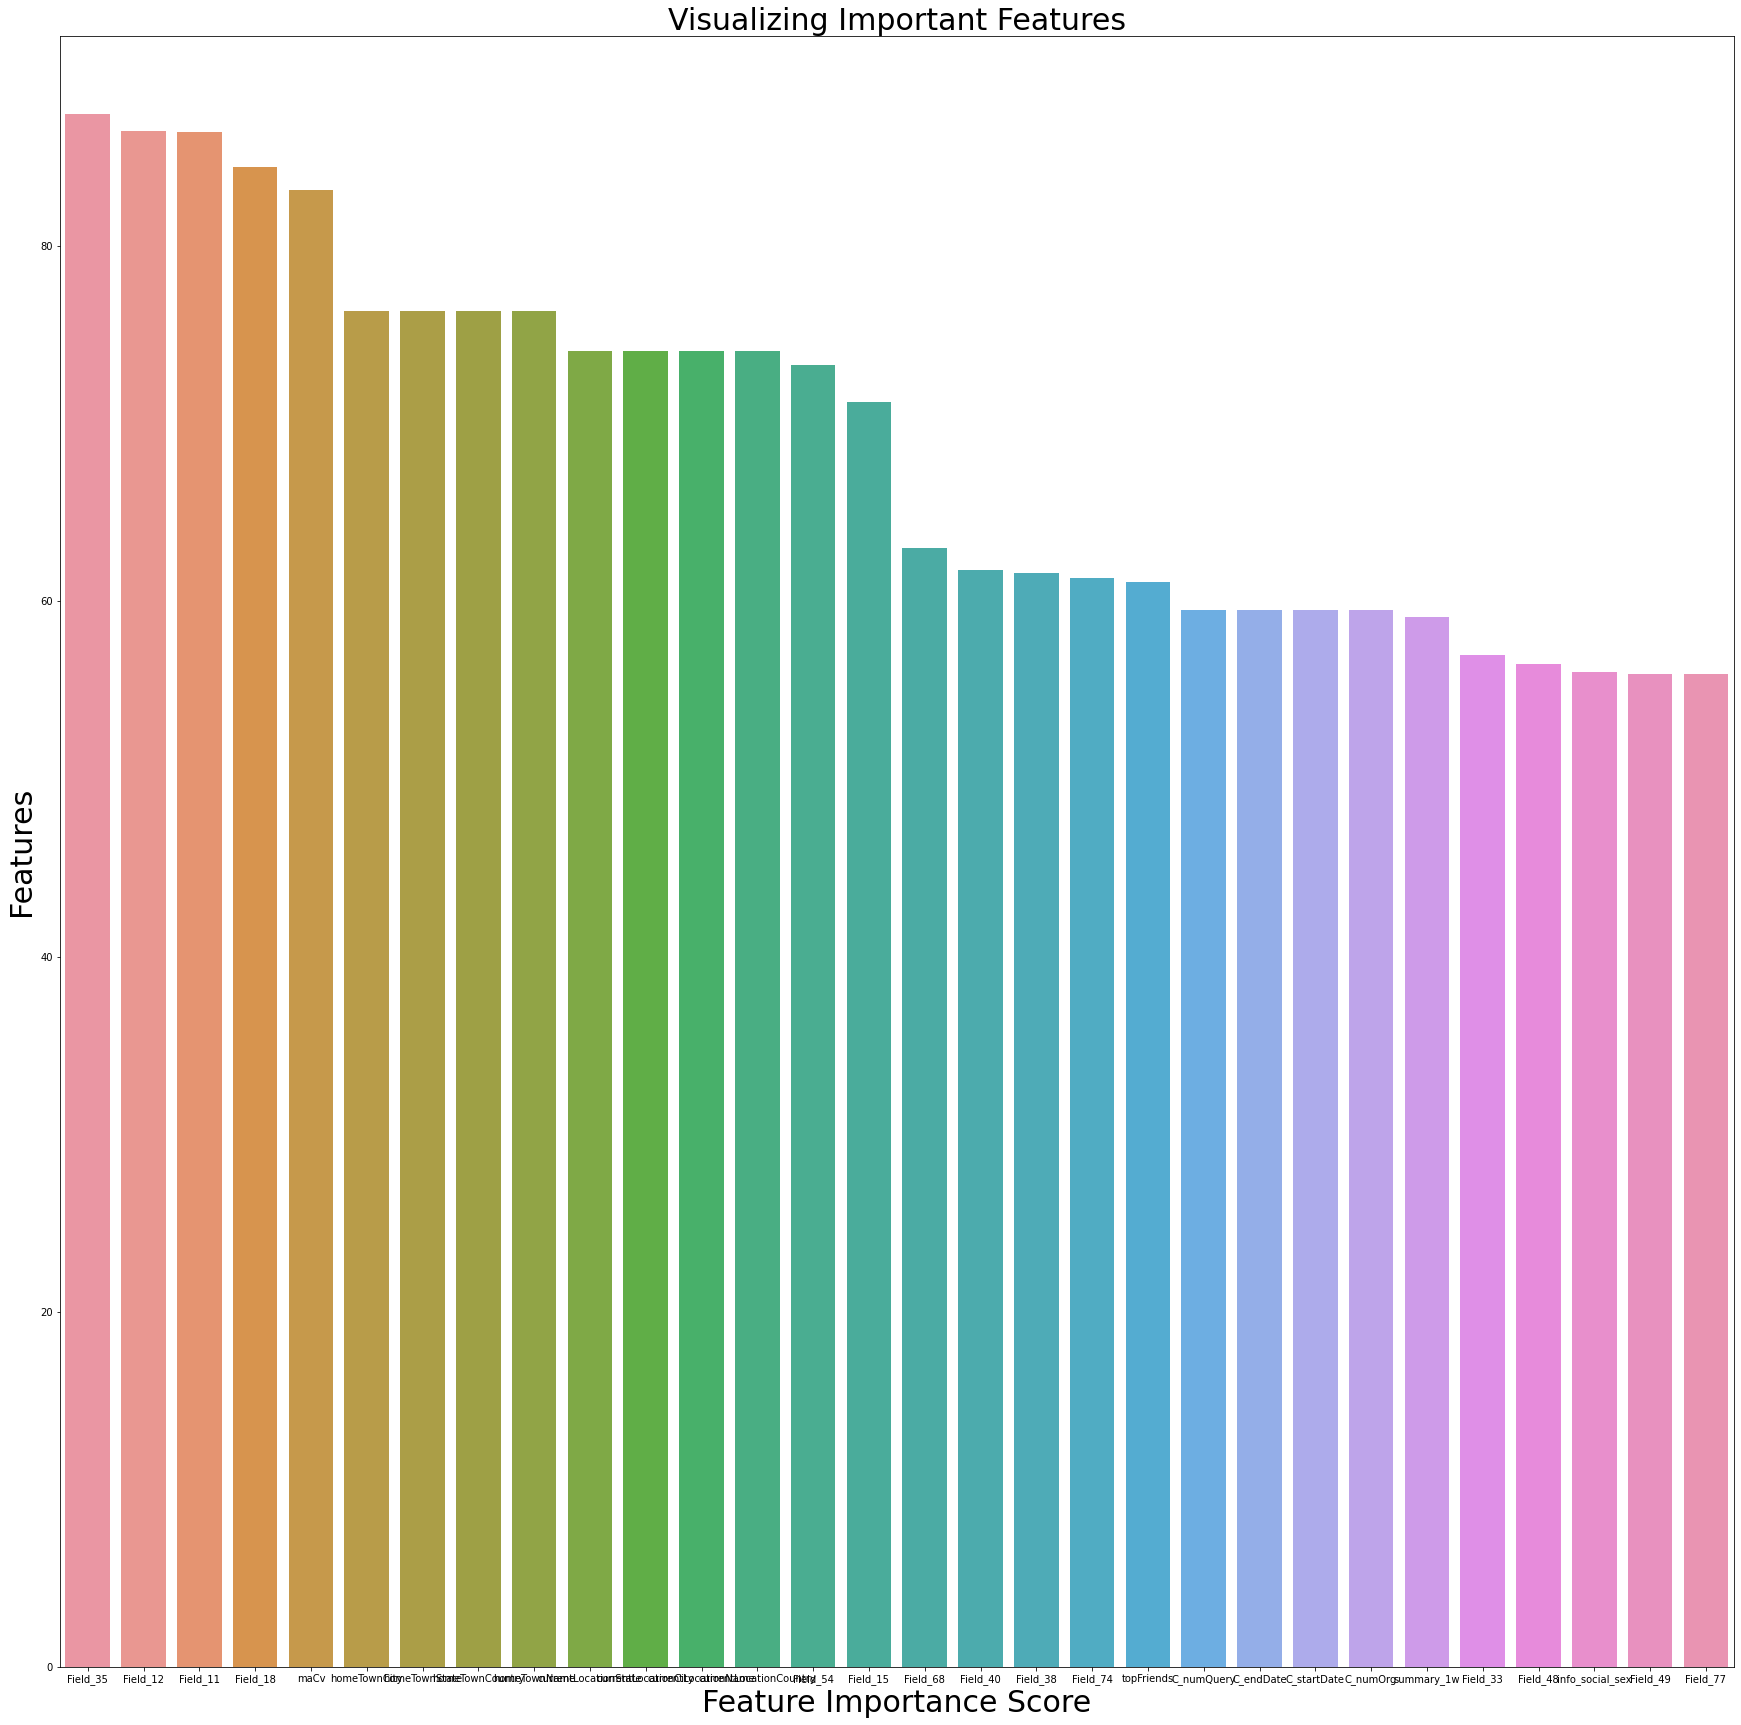

In [ ]:
# plt.figure(figsize = (10, 10))
# plt.xticks(rotation='90')

# plt.xlabel('Features', fontsize=10)
# plt.ylabel('Percent of missing values', fontsize=10)
# plt.title('Percent missing data by feature', fontsize=10)

import seaborn as sns
%matplotlib inline
# Creating a bar plot
plt.figure(figsize = (30, 30))
sns.barplot(x=missing_data.head(30).index, y=missing_data['Percent'].head(30))

# Add labels to your graph
plt.xlabel('Feature Importance Score', fontsize=30)
plt.ylabel('Features', fontsize=30)
plt.title("Visualizing Important Features", fontsize=30)
#plt.legend()
plt.show()

# <a id='label'> Imbalanced data</a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e9d195710>,
      dtype=object)

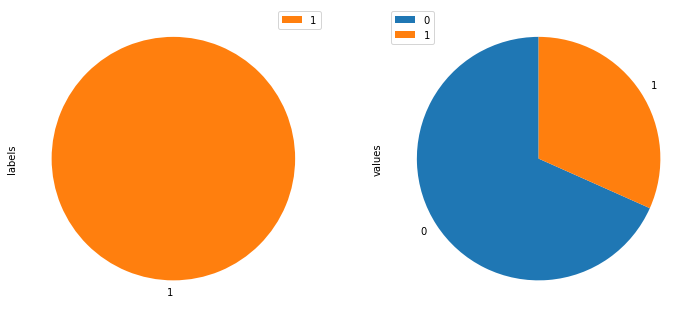

In [ ]:
temp = df["label"].value_counts()
label_df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
label_df.plot(kind='pie', startangle=90, figsize=(12,12), subplots=True)

# <a id='un'> Check for unknown data</a>

In [ ]:
result #.to_csv('Unknown_data.csv', index = True)

,Feature name,Train unique,Test unique,Unknown value
0,Field_4,3,3,0
1,Field_18,6563,2660,2128
2,Field_12,8,8,0
3,Field_34,2636,1908,465
4,Field_36,35,30,0
5,Field_38,7,6,0
6,Field_45,10957,5439,2398
7,Field_46,14311,6553,3591
8,Field_47,6,6,0
9,Field_48,12650,5901,3110


In [10]:
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

train_df = train
test_df = test
for col in cat_field:
    lb = LabelEncoder()
    lb.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train_df[col] = lb.transform(list(train[col].values.astype('str')))
    test_df[col] = lb.transform(list(test[col].values.astype('str')))
for col in time_field:
    train_df[col] = pd.to_datetime(train_df[col]).map(datetime.toordinal)
    test_df[col] = pd.to_datetime(test_df[col]).map(datetime.toordinal)
train_df.fillna(-999, inplace = True)

# <a id='corr'> Correlation of features</a>

In [ ]:
# import seaborn as sns
# corr = train_df.corr()
# sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
# plt.figure(figsize=(13,7))
# a = sns.heatmap(corr, annot=True, fmt='.2f')
# rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
# roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

Error in callback <function flush_figures at 0x7f3ed28472f0> (for post_execute):


KeyboardInterrupt: ignored

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_leaf=4, max_features=0.5, random_state=42)
rf.fit(train_df.drop(['id', 'label'],axis=1), train_df.label)
features = train_df.drop(['id', 'label'],axis=1).columns.values

# <a id='imp'> Feature importaces</a>

In [14]:
temp_df = train_df.drop(columns= ['id', 'label'])

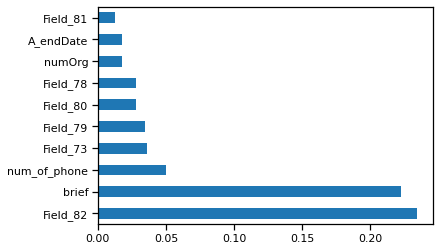

In [ ]:
# feat_importances = pd.Series(rf.feature_importances_, index=temp_df.columns)
# feat_importances.nlargest(10).plot(kind='barh')

In [17]:
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
  fi_df.to_csv('imp.csv', index= False)
  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'].head(10), y=fi_df['feature_names'].head(10))
  #Add chart labels
  #plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('Tương quan')
  plt.ylabel('Thuộc tính')

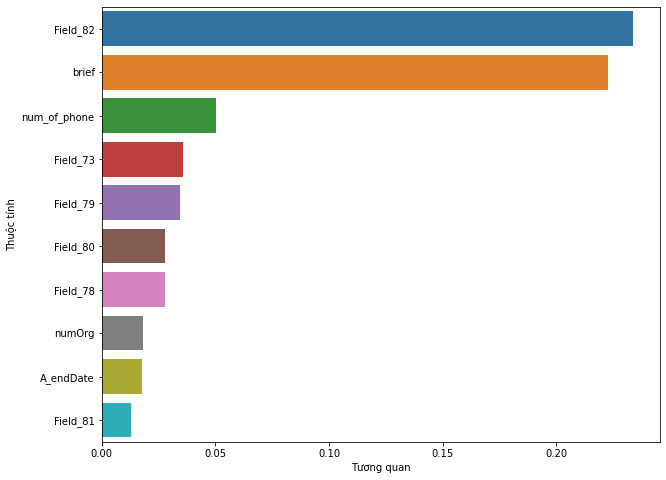

In [19]:
plot_feature_importance(rf.feature_importances_,temp_df.columns,'RANDOM FOREST')

# <a id='dis'> Distribution </a>

In [ ]:
for field in num_field:
    try:
        plt.figure(figsize=(12,5))
        plt.title("Distribution of " + field)
        ax = sns.distplot(train[field])
    except:
        plt.figure(figsize=(12,5))
        plt.title("Distribution of "+ field)
        ax = sns.distplot(train[field], kde=False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def visual_percentage(field):
    temp = train[field].value_counts()
    fig = {
      "data": [
        {
          "values": temp.values,
          "labels": temp.index,
          "domain": {"x": [0, .48]},
          #"name": "Types of Loans",
          #"hoverinfo":"label+percent+name",
          "hole": .7,
          "type": "pie"
        },

        ],
      "layout": {
            "annotations": [
                {
                    "font": {
                        "size": 20
                    },
                    "showarrow": False,
                    "text": field,
                    "x": 0.17,
                    "y": 0.5
                }

            ]
        }
    }
    iplot(fig, filename='donut')

In [ ]:
visual_percentage('Field_4')
visual_percentage('Field_12')
visual_percentage('Field_47')
visual_percentage('Field_61')
visual_percentage('Field_62')
visual_percentage('Field_65')
visual_percentage('Field_66')
visual_percentage('info_social_sex')
visual_percentage('brief')